In [1]:
from pathlib import Path
from tifffile import TiffFile, imwrite
from imaris_ims_file_reader import ims


BASE_DIR = Path(r'F:/spatial_data/raw')
RUN_ID = '20240917_PRISM64_3D_confocal_MouseBrain_TH_new_sample'
src_dir = BASE_DIR / f'{RUN_ID}'

OUT_DIR = Path(r'F:/spatial_data/processed')
out_dir = OUT_DIR / f'{RUN_ID}_processed'
stc_dir = out_dir / 'stitched'
stc_dir.mkdir(parents=True, exist_ok=True)

## Get multi-channel tif

In [2]:
# Extract image from different channels
resolution_level = 0
ims_file = ims(stc_dir/'combined.ims', ResolutionLevelLock=resolution_level)

Opening readonly file: F:\spatial_data\processed\20240917_PRISM64_3D_confocal_MouseBrain_TH_new_sample_processed\stitched\combined.ims 



In [3]:
channel_map = {
    0: 'cy5',
    1: 'TxRed',
    2: 'cy3',
    3: 'FAM',
    4: 'DAPI',
}
for i, channel in channel_map.items()[:4]:
    image = ims_file[0, i, :, :, :]
    image_path = stc_dir / f'{channel}.tif'
    imwrite(image_path, image[:, :, :])
    with TiffFile(image_path) as tif:
        page = tif.pages[0]
        y_size = page.tags['ImageLength'].value
        x_size = page.tags['ImageWidth'].value
        z_size = len(tif.pages)
        shape = (z_size, y_size, x_size)
    print(f'channel:{channel}, shape: {shape}, image_path: {image_path}')

# Register?
# Then run arilocalize

channel:cy5, shape: (100, 4096, 4096), image_path: F:\spatial_data\processed\20240917_PRISM64_3D_confocal_MouseBrain_TH_new_sample_processed\stitched\cy5.tif
channel:TxRed, shape: (100, 4096, 4096), image_path: F:\spatial_data\processed\20240917_PRISM64_3D_confocal_MouseBrain_TH_new_sample_processed\stitched\TxRed.tif
channel:cy3, shape: (100, 4096, 4096), image_path: F:\spatial_data\processed\20240917_PRISM64_3D_confocal_MouseBrain_TH_new_sample_processed\stitched\cy3.tif
channel:FAM, shape: (100, 4096, 4096), image_path: F:\spatial_data\processed\20240917_PRISM64_3D_confocal_MouseBrain_TH_new_sample_processed\stitched\FAM.tif


## Multi-channel readout

In [24]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.feature import peak_local_max
from skimage.io import imread
from skimage.io import imsave
from tifffile import TiffFile, imwrite
from skimage.morphology import dilation
from pathlib import Path
from scipy.spatial import KDTree
import cv2
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})

BASE_DIR = Path(r'F:\spatial_data\processed')
RUN_ID = '20240917_PRISM64_3D_confocal_MouseBrain_TH_new_sample'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
read_dir.mkdir(exist_ok=True, parents=True)

CHANNELS = ['cy5', 'TxRed', 'cy3', 'FAM']
Q_CHANNELS = ['cy5', 'TxRed', 'FAM']

In [2]:
def extract_coordinates(image, snr=4, quantile=0.96):
    meta = {}
    coordinates = peak_local_max(image,min_distance=2,threshold_abs=snr*np.mean(image))
    meta['Coordinates brighter than given SNR'] = coordinates.shape[0]
    meta['Image mean intensity'] = float(np.mean(image))
    intensities = image[coordinates[:,0],coordinates[:,1]]
    meta[f'{quantile} quantile'] = float(np.quantile(intensities,quantile))
    threshold = np.quantile(intensities,quantile)
    coordinates = coordinates[image[coordinates[:,0],coordinates[:,1]]>threshold]
    meta['Final spots count'] = coordinates.shape[0]
    return coordinates

# convert Maxima(x,y) to image
# coordinates_R_1 = intensity_R[['Y','X']].to_numpy()
def find_signal(coordinates,im):
    Maxima = np.zeros(im.shape,dtype=np.uint16)
    Maxima[coordinates[:,0],coordinates[:,1]] = 255
    im[Maxima<=0] = 0 # Mask
    return im
TOPHAT_KERNEL_SIZE = 7
def tophat_spots(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(TOPHAT_KERNEL_SIZE,TOPHAT_KERNEL_SIZE))
    return cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
def build_maxima (coordinates,shape):
    Maxima = np.zeros(shape,dtype=np.uint16)
    Maxima[coordinates['z_in_pix'],coordinates['x_in_pix'],coordinates['y_in_pix']] = coordinates['integratedIntensity']
    return Maxima

In [4]:
intensity_dict = dict()
for channel in CHANNELS:
    df = pd.read_csv(read_dir / 'tmp' / f'{channel}.loc4', sep='\t')[['x_in_pix','y_in_pix','z_in_pix','integratedIntensity']]
    df['integratedIntensity'] = round(df['integratedIntensity']/200)
    df['x_in_pix'] = round(df['x_in_pix'])-1
    df['y_in_pix'] = round(df['y_in_pix'])-1
    df['z_in_pix'] = round(df['z_in_pix'])-1
    df = df.astype({'x_in_pix':int, 'y_in_pix':int, 'z_in_pix':int, 'integratedIntensity':int})
    intensity_dict[channel] = df

In [5]:
# Dilation: 3 by 3
kernel = np.ones((5,5,5), dtype=np.uint16)

example_channel = 'cy5'
with TiffFile(stc_dir/f'{example_channel}.tif') as tif:
    page = tif.pages[0]
    y_size = page.tags['ImageLength'].value
    x_size = page.tags['ImageWidth'].value
    z_size = len(tif.pages)
    shape = (z_size, y_size, x_size)

for channel in tqdm(CHANNELS, desc='Dilation'):
    image = build_maxima(intensity_dict[channel], shape)
    image = dilation(image, selem=kernel)
    imwrite(read_dir / 'tmp' / f'{channel}_dilated.tif', image)

Dilation: 100%|██████████| 4/4 [04:54<00:00, 73.74s/it]


In [6]:
dilated_image_dict = dict()
for channel in tqdm(CHANNELS, desc='Reading images'):
    dilated_image_dict[channel] = imread(read_dir / 'tmp' / f'{channel}_dilated.tif')

for q_channel in tqdm(Q_CHANNELS, position=0, leave=True, desc='Extracting signal'):
    df = intensity_dict[q_channel]    
    for channel in tqdm(CHANNELS, position=1, leave=False, desc=f'Spots in {q_channel}'):
        df[channel] = dilated_image_dict[channel][df['z_in_pix'],df['x_in_pix'],df['y_in_pix']]

intensity_all = pd.concat([intensity_dict[channel] for channel in Q_CHANNELS])#,keys=['R','Ye','B','G'])
intensity_all = intensity_all.drop(columns='integratedIntensity') #integratedIntensity
intensity_all = intensity_all.reset_index(drop=True)
intensity_all.head()

Extracting signal: 100%|██████████| 3/3 [00:00<00:00, 11.51it/s]


,x_in_pix,y_in_pix,z_in_pix,cy5,TxRed,cy3,FAM
0,1208,1009,12,65201,44370,0,0
1,2266,1352,14,59772,40729,23239,36739
2,2266,1363,14,58001,41227,22762,36957
3,1335,964,12,56947,42254,22574,38984
4,1333,968,12,56417,37358,21180,35670


In [7]:
median_dict = dict()
# Scale colors to similar range
for channel in CHANNELS:
    a_scale = intensity_all[channel]
    a_scale = a_scale[a_scale>0]
    median_dict[channel] = np.median(np.unique(a_scale))
    print(channel,':', median_dict[channel])

cy5 : 10155.5
TxRed : 9628.5
cy3 : 7235.0
FAM : 12179.5


In [28]:
channel_name_map = {
    'cy5': 'R',
    'TxRed': 'Ye',
    'cy3': 'G',
    'FAM': 'B',
}
for channel in median_dict.keys():
    intensity_all[f'Scaled_{channel_name_map[channel]}'] = (intensity_all[channel] / median_dict[channel] * 5000).astype(int)
intensity_all['sum'] = intensity_all[['Scaled_R', 'Scaled_Ye', 'Scaled_B', ]].sum(axis=1)

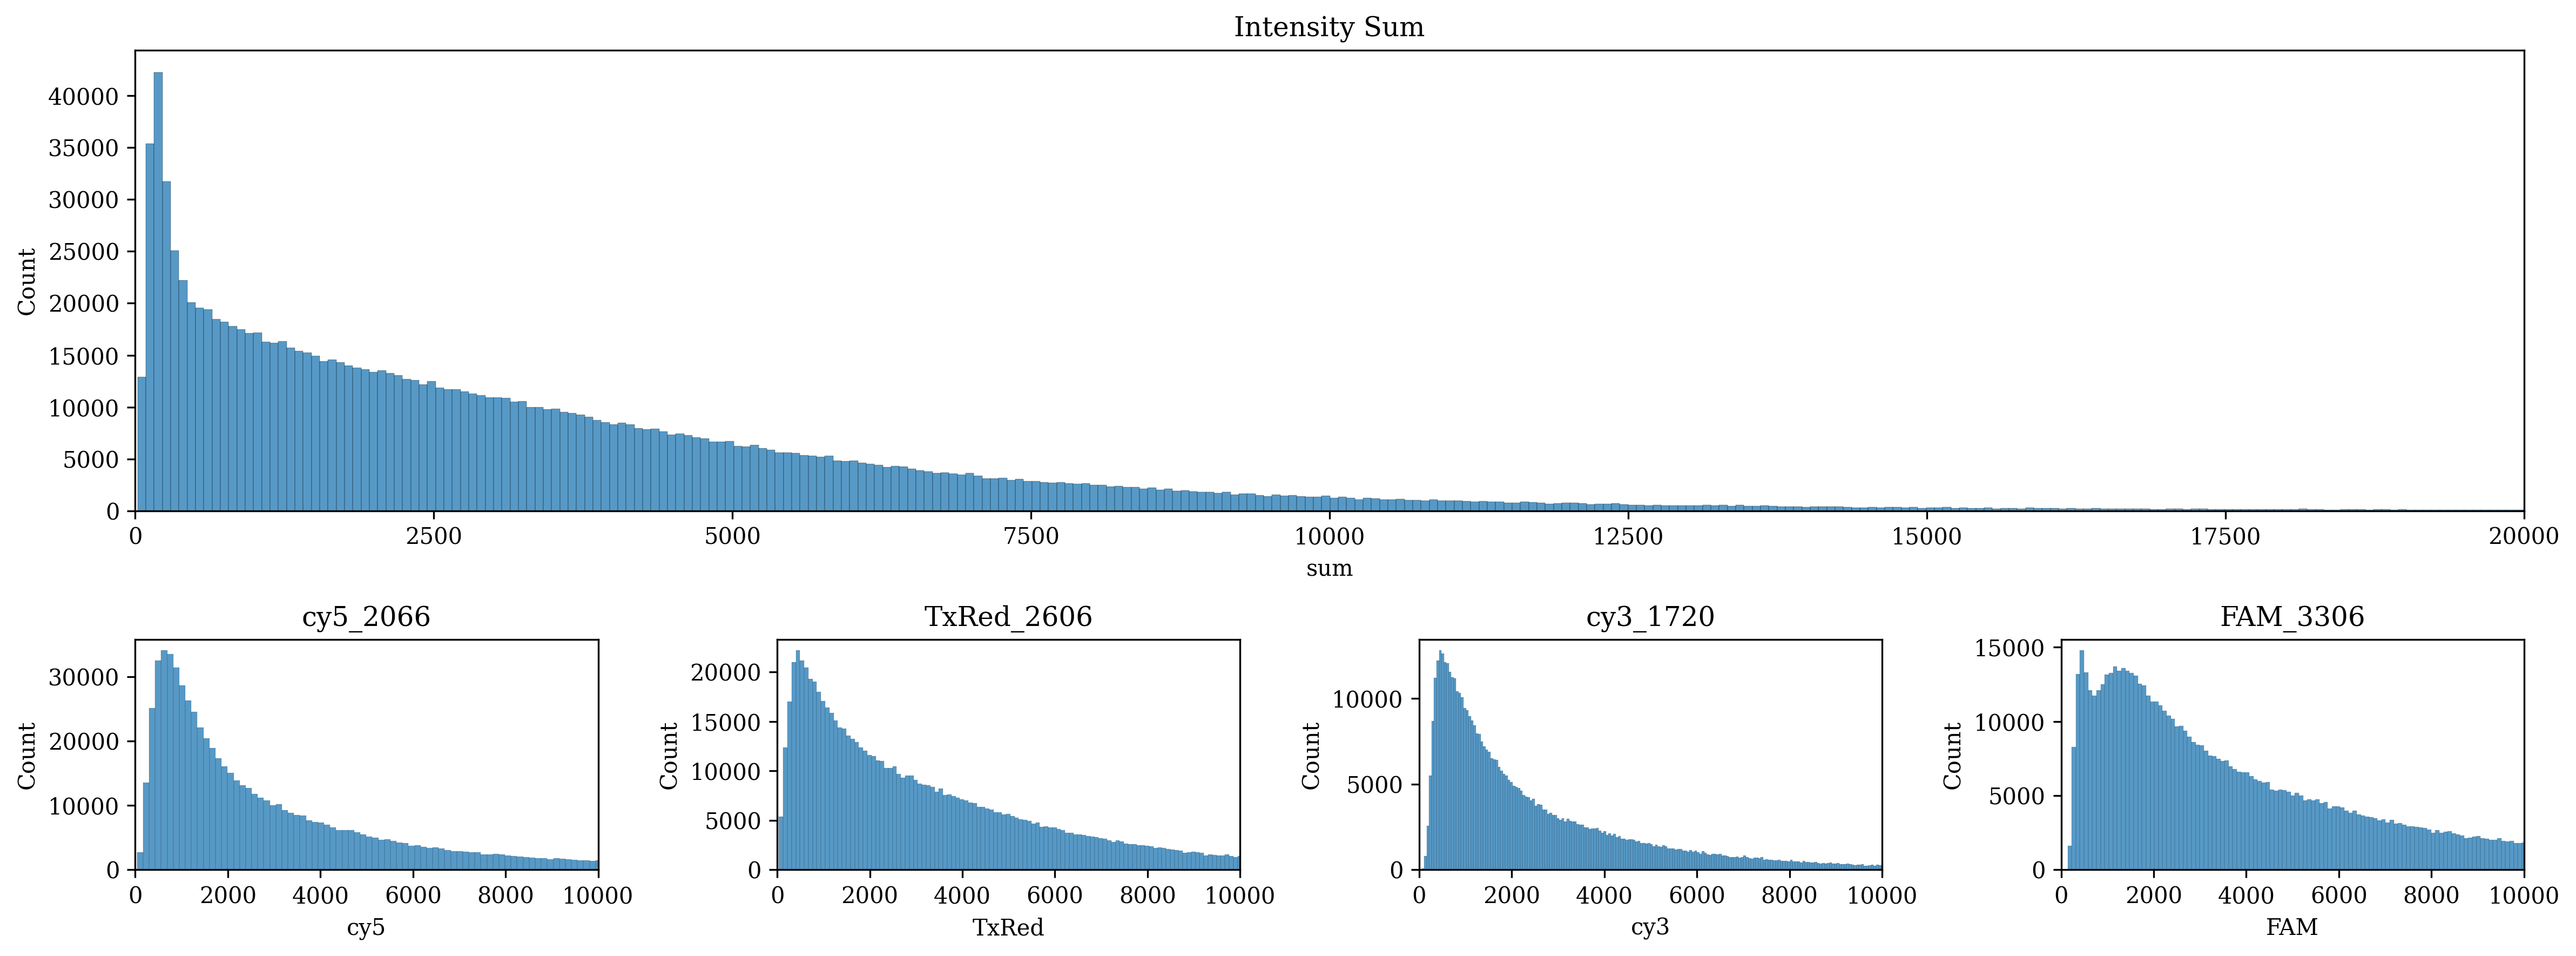

In [30]:
# set 1 subplot on the above and 4 on the below
# the above subplot is the histogram of intensity sum column
# the below subplots are the histogram of each channel
# use gridspec to make the 1 row one subplot
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(2, 4, height_ratios=[2, 1])
ax0 = plt.subplot(gs[0,:])

sns.histplot(intensity_all['sum'], bins=1000, ax=ax0)
ax0.set_xlim((0,20000))
ax0.set_title('Intensity Sum')

for i, channel in enumerate(CHANNELS):
    ax = plt.subplot(gs[1, i])
    sns.histplot(intensity_all.loc[intensity_all[channel]>0, channel], bins=500, ax=ax)
    median = intensity_all.loc[intensity_all[channel]>0, channel].median()
    ax.set_xlim((0,10000))
    ax.set_title(f'{channel}_{median:.0f}')

plt.tight_layout()
plt.show()

In [31]:
#filter by sum value (QC)
intensity_all = intensity_all[(intensity_all['sum'] > 0) & (intensity_all['sum'] < 15000)]
intensity_all.to_csv(read_dir / 'intensity_all.csv')
print(len(intensity_all))
intensity_all.head()

1242400


,x_in_pix,y_in_pix,z_in_pix,cy5,TxRed,cy3,FAM,Scaled_R,Scaled_Ye,Scaled_G,Scaled_B,sum
223,2744,1489,94,30444,0,8756,0,14988,0,6051,0,14988
225,1667,164,86,30408,0,0,0,14971,0,0,0,14971
227,2633,1189,92,30375,0,0,0,14954,0,0,0,14954
228,874,1126,89,30373,0,5157,0,14953,0,3563,0,14953
234,1006,2655,15,30286,0,6936,0,14911,0,4793,0,14911


In [ ]:
# intensity_all.to_csv(read_dir/'PRISM_Spot_intensity.csv')
intensity_all['R/A'] = intensity_all['Scaled_R'] / intensity_all['sum']
intensity_all['Ye/A'] = intensity_all['Scaled_Ye'] / intensity_all['sum']
intensity_all['B/A'] = intensity_all['Scaled_B'] / intensity_all['sum']
intensity_all['G/A'] = intensity_all['Scaled_G'] / intensity_all['sum']
intensity_all['X_coor'] = 2*intensity_all['R/A'] - 1
intensity_all['Y_coor'] = intensity_all['B/A'] - intensity_all['Ye/A']
intensity_all

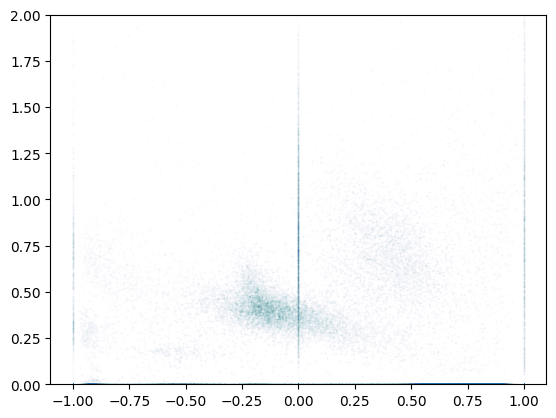

In [16]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.scatter(intensity_all['Y_coor'],intensity_all['G/A'],s=0.3,alpha=0.01,linewidths=None)
plt.ylim([0,2])
plt.xlim([-1.1,1.1])
plt.savefig('0G_1G.jpg')

In [17]:
intensity_low = intensity_all[intensity_all['G/A']<=0.05]
intensity_high = intensity_all[intensity_all['G/A']>=0.2]

Exception ignored in: <function ims_reader.__del__ at 0x0000024B74D82D30>
Traceback (most recent call last):
  File "e:\anaconda3\envs\star2\lib\site-packages\imaris_ims_file_reader\ims.py", line 194, in __del__
    self.close()
  File "e:\anaconda3\envs\star2\lib\site-packages\imaris_ims_file_reader\ims.py", line 202, in close
    if self.hf is not None:
AttributeError: 'ims_reader' object has no attribute 'hf'
Exception ignored in: <function ims_reader.__del__ at 0x0000024B74D82D30>
Traceback (most recent call last):
  File "e:\anaconda3\envs\star2\lib\site-packages\imaris_ims_file_reader\ims.py", line 194, in __del__
    self.close()
  File "e:\anaconda3\envs\star2\lib\site-packages\imaris_ims_file_reader\ims.py", line 202, in close
    if self.hf is not None:
AttributeError: 'ims_reader' object has no attribute 'hf'


Peaks range of RY [(-1.0, -0.99), (-0.73, -0.64), (-0.63, -0.5800000000000001), (-0.5700000000000001, -0.33999999999999997), (-0.32999999999999996, -0.21999999999999997), (-0.20999999999999996, -0.13), (-0.12, -0.030000000000000027), (-0.020000000000000018, 0.15999999999999992), (0.16999999999999993, 0.28), (0.29000000000000004, 0.3400000000000001), (0.99, 1.0)] 

Closing file: F:\CTY\2024\0904-30um-880\try2\try2.ims 

Closing file: F:\CTY\2024\0904-30um-880\try2\try2.ims 

Peaks range of RB [(-1.0, -0.99), (-0.7, -0.52), (-0.51, -0.42999999999999994), (-0.42000000000000004, -0.32999999999999996), (-0.31999999999999995, -0.18999999999999995), (-0.17999999999999994, -0.040000000000000036), (-0.030000000000000027, 0.18999999999999995), (0.19999999999999996, 0.3500000000000001), (0.3600000000000001, 0.43999999999999995), (0.44999999999999996, 0.55), (0.56, 0.6799999999999999), (0.99, 1.0)] 

Peaks range of BY [(-1.0, -0.99), (-0.6499999999999999, -0.10999999999999999), (-0.099999999999999

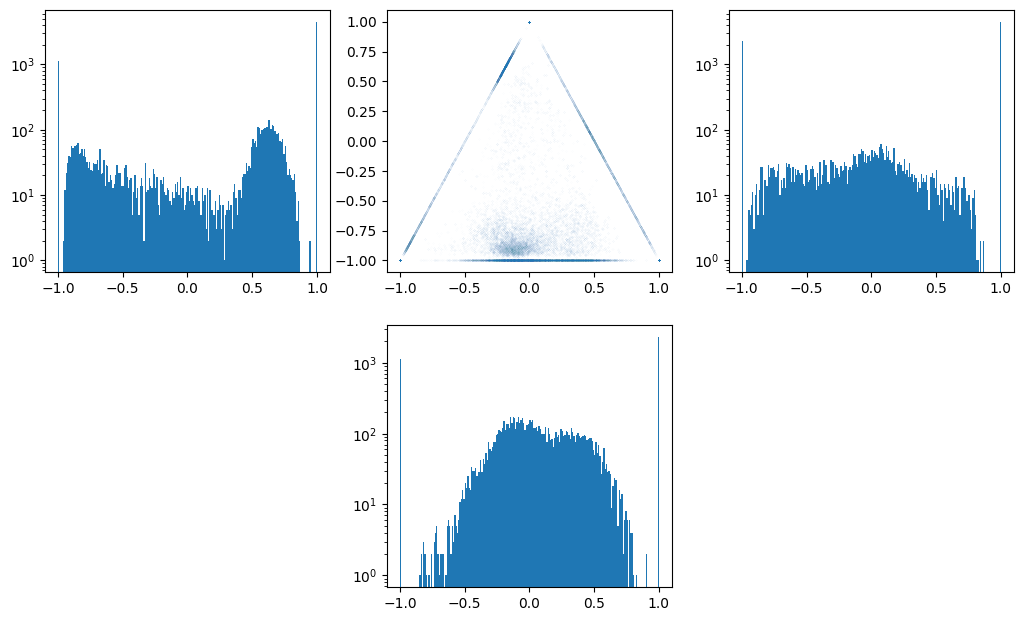

In [18]:
from xml.dom.expatbuilder import InternalSubsetExtractor
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})
import matplotlib.pyplot as plt
plt.style.use('default')

def plot_freq(intensity, colorline, layer='1G', layer_threshold=0.25, order=5, contraction=0, vlines=True, curvefit_range=None, curvefit_p0=None,curvefit_pvalue=0.1, curvefit_colorset=['red', 'yellow', 'green'], save=False, read_dir=None):
    '''
    Plot a frequency plot.

    Parameters
    -----------
    intensity: pandas dataframe.
    colorline: projection line. 'RY', 'RB' or 'BY'.
    layer: the 4th color. '0G' or '1G'.
    layer_threshold: threshold of the 4th color. For '0G', it is the upper limit. For '1G', it is the lower limit.
    order: how many points on each side to use for the comparison to consider. For details, see scipy.signal.argrelextrema.
    contraction: distance between two peaks (= contraction*2). 
    vlines: whether to plot peak boundaries or not.
    curvefit_range: peak range to fit curve.
    curvefit_p0: initial guess for the parameters (length N). For details, see scipy.optimize.curve_fit.
    save: whether to save the plot alone.
    read_dir: 
    '''
    
    def gaussian(x, mu, sigma, A):
        return A*np.exp(-(x-mu)**2/(2*(sigma**2)))

    def mixgaussian(x, mu1, mu2, mu3, sigma1, sigma2, sigma3, A1, A2, A3):
        return gaussian(x, mu1, sigma1, A1) + gaussian(x, mu2, sigma2, A2) + gaussian(x, mu3, sigma3, A3)

    if layer == '0G':
        intensity = intensity[intensity['G/A'] <= layer_threshold]
    elif layer == '1G':
        intensity = intensity[intensity['G/A'] >= layer_threshold]

    if colorline == 'RY':
        intensity = intensity[intensity['B/A'] == 0] 
        intensity = intensity['R/A'] - intensity['Ye/A']
    elif colorline == 'RB':
        intensity = intensity[intensity['Ye/A'] == 0]
        intensity = intensity['R/A'] - intensity['B/A']
    elif colorline == 'BY':
        intensity = intensity[intensity['R/A'] == 0]
        intensity = intensity['B/A'] - intensity['Ye/A']
    
   
    hist=plt.hist(pd.DataFrame(intensity), bins = 200,log=True)


    freq, bins = hist[0], hist[1]
    extrema_less = argrelextrema(freq, np.less, order=order)[0] # assuming two side have 0, execute this code, or skip it
    # extrema_less = np.insert(extrema_less, 0, 3)
    # extrema_less = np.append(extrema_less, -3)
    bins_less = [(bins[extrema_less[i-1]+1]+contraction, bins[extrema_less[i]]-contraction) if i>0 else (bins[0], bins[1]) for i in range(len(extrema_less))]
    bins_less.append((bins[-2], bins[-1]))
    print('Peaks range of', colorline, bins_less, '\n')

    if vlines:
        plt.vlines([i[0] for i in bins_less], 0, 10000, linestyles='dashed', colors='red')
        plt.vlines([i[1] for i in bins_less], 0, 10000, linestyles='dashed', colors='green')

    if curvefit_range:
        confidence = 1 - curvefit_pvalue
        if confidence == 0.9:
            z = 1.28
        elif confidence == 0.95:
            z = 1.64
        start_idx, end_idx = curvefit_range[0], curvefit_range[1]
        bins_ = (bins[1:] + bins[:-1])/2 # for len(bins_) == len(freq)
        popt, pcov = curve_fit(mixgaussian, bins_[start_idx:end_idx], freq[start_idx:end_idx], p0=curvefit_p0, maxfev=1000000)
        # print('Fitting parameters: mu1, mu2, mu3, sigma1, sigma2, sigma3, A1, A2, A3\n', popt, '\n')
        # plt.plot(bins_[start_idx:end_idx], mixgaussian(bins_[start_idx:end_idx], *popt))

        # plot fitting curve separately: curve 1, curve 2, curve 3
        # curve 1
        mu, sigma, A = popt[0], popt[3], popt[6]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[0])
        print('Gaussian Curve 1: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])
        # curve 2
        mu, sigma, A = popt[1], popt[4], popt[7]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[1])
        print('Gaussian Curve 2: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])
        # curve 3
        mu, sigma, A = popt[2], popt[5], popt[8]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[2])
        print('Gaussian Curve 3: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])

    if save:
        if read_dir:
            plt.savefig(read_dir / (colorline+'_'+layer+'.jpg'))
        else:
            print('Input a read_dir to save the plot.\n') # Maybe a warning or error

# plots: scatter + frequency plot in three dimension
fig = plt.figure()    # 生成新的画布fig
fig.set_size_inches(12.5, 7.5)     # 调整画布为合适大小

p0 = [-1, 1, 1, 1, 3, 3]
plt.subplot(232)  # scatter
plt.scatter(intensity_high['Y_coor'], intensity_high['X_coor'], s=0.009, alpha=0.08, linewidths=None)
plt.subplot(231)   # red-yellow
plot_freq(intensity_all, colorline='RY', layer='1G', layer_threshold=0.2, vlines=False)#, curvefit_range=(10,190), curvefit_p0=(-0.5, 0, 0.5, 0.1, 0.1, 0.1, 1500, 1500, 22000),curvefit_colorset=['gold', 'darkorange', 'orangered'])#, save=True, read_dir=src_dir / 'readout')
#plt.ylim([0,1000])
#plt.xlim([-1.2,1.2])
plt.subplot(233)   # red-blue
plot_freq(intensity_all, colorline='RB', layer='1G', layer_threshold=0.2, vlines=False)#, curvefit_range=(10,190), curvefit_p0=(-0.7, -0.25, 0.35, 0.1, 0.1, 0.1, 5000, 5000, 5000),curvefit_colorset=['darkviolet', 'magenta', 'deeppink'])#, save=True, read_dir=src_dir / 'readout')
#plt.ylim([0,1000])
#plt.xlim([-1.2,1.2])
plt.subplot(235)   # yellow-blue
plot_freq(intensity_all, colorline='BY', layer='1G', layer_threshold=0.2, vlines=False)#, save=True, read_dir=src_dir / 'readout')#, curvefit_range=(20,190), curvefit_p0=(-0.4, 0.2, 0.6, 0.1, 0.1, 0.1, 3000, 10000, 20000),curvefit_colorset=['greenyellow', 'springgreen', 'deepskyblue'], save=True, read_dir=src_dir / 'readout')
#plt.ylim([0,1000])
#plt.xlim([-1.2,1.2])
plt.show()


Peaks range of RY [(-1.0, -0.9933333333333333), (-0.6266666666666667, -0.45999999999999996), (-0.45333333333333325, -0.3666666666666666), (-0.36, -0.32666666666666666), (-0.31999999999999995, -0.16666666666666663), (-0.15999999999999992, -0.07333333333333325), (-0.06666666666666665, 0.03333333333333344), (0.040000000000000036, 0.11333333333333351), (0.1200000000000001, 0.26), (0.26666666666666683, 0.44666666666666677), (0.45333333333333337, 0.5733333333333335), (0.9933333333333334, 1.0)] 

Peaks range of RB [(-1.0, -0.9933333333333333), (-0.7, -0.62), (-0.6133333333333333, -0.5466666666666666), (-0.54, -0.5), (-0.4933333333333333, -0.44666666666666666), (-0.43999999999999995, -0.38), (-0.3733333333333333, -0.31999999999999995), (-0.31333333333333324, 0.1200000000000001), (0.1266666666666667, 0.20666666666666678), (0.21333333333333337, 0.2466666666666668), (0.2533333333333334, 0.32000000000000006), (0.32666666666666666, 0.3733333333333335), (0.3800000000000001, 0.4800000000000002), (0.4

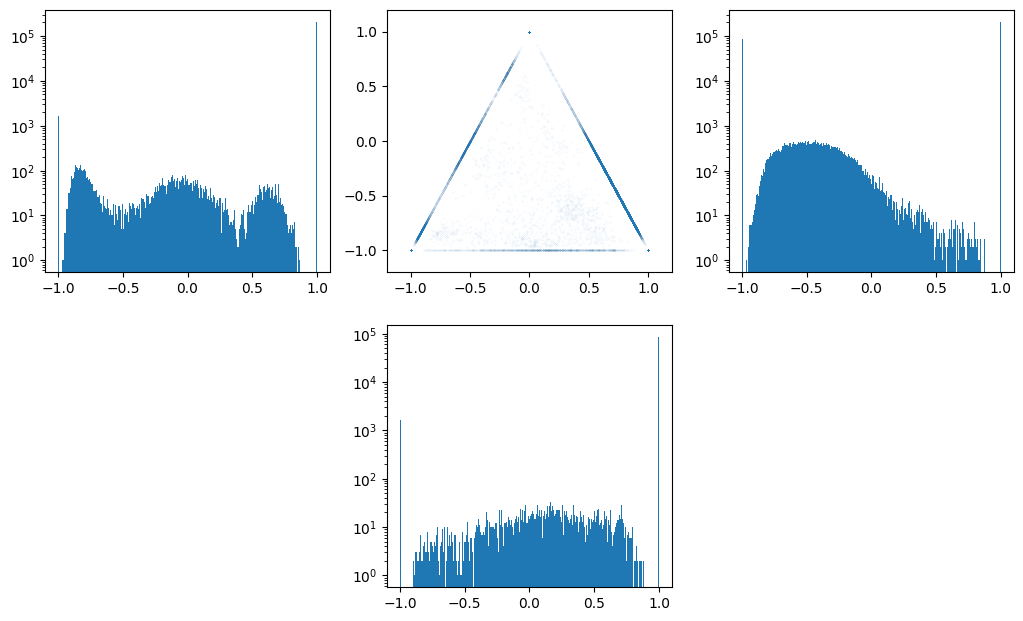

In [19]:
from xml.dom.expatbuilder import InternalSubsetExtractor
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})

import matplotlib.pyplot as plt
plt.style.use('default')
def plot_freq(intensity, colorline, layer='1G', layer_threshold=0.25, order=5, contraction=0, vlines=True, curvefit_range=None, curvefit_p0=None,curvefit_pvalue=0.1, curvefit_colorset=['red', 'yellow', 'green'], save=False, read_dir=None):
    '''
    Plot a frequency plot.

    Parameters
    -----------
    intensity: pandas dataframe.
    colorline: projection line. 'RY', 'RB' or 'BY'.
    layer: the 4th color. '0G' or '1G'.
    layer_threshold: threshold of the 4th color. For '0G', it is the upper limit. For '1G', it is the lower limit.
    order: how many points on each side to use for the comparison to consider. For details, see scipy.signal.argrelextrema.
    contraction: distance between two peaks (= contraction*2). 
    vlines: whether to plot peak boundaries or not.
    curvefit_range: peak range to fit curve.
    curvefit_p0: initial guess for the parameters (length N). For details, see scipy.optimize.curve_fit.
    save: whether to save the plot alone.
    read_dir: 
    '''
    
    def gaussian(x, mu, sigma, A):
        return A*np.exp(-(x-mu)**2/(2*(sigma**2)))

    def mixgaussian(x, mu1, mu2, mu3, sigma1, sigma2, sigma3, A1, A2, A3):
        return gaussian(x, mu1, sigma1, A1) + gaussian(x, mu2, sigma2, A2) + gaussian(x, mu3, sigma3, A3)

    if layer == '0G':
        intensity = intensity[intensity['G/A'] <= layer_threshold]
    elif layer == '1G':
        intensity = intensity[intensity['G/A'] >= layer_threshold]

    if colorline == 'RY':
        intensity = intensity[intensity['B/A'] == 0] 
        intensity = intensity['R/A'] - intensity['Ye/A']
    elif colorline == 'RB':
        intensity = intensity[intensity['Ye/A'] == 0]
        intensity = intensity['R/A'] - intensity['B/A']
    elif colorline == 'BY':
        intensity = intensity[intensity['R/A'] == 0]
        intensity = intensity['B/A'] - intensity['Ye/A']

    hist = plt.hist(pd.DataFrame(intensity), bins = 300,log=True)
    freq, bins = hist[0], hist[1]
    extrema_less = argrelextrema(freq, np.less, order=order)[0] # assuming two side have 0, execute this code, or skip it
    # extrema_less = np.insert(extrema_less, 0, 3)
    # extrema_less = np.append(extrema_less, -3)
    bins_less = [(bins[extrema_less[i-1]+1]+contraction, bins[extrema_less[i]]-contraction) if i>0 else (bins[0], bins[1]) for i in range(len(extrema_less))]
    bins_less.append((bins[-2], bins[-1]))
    print('Peaks range of', colorline, bins_less, '\n')

    if vlines:
        plt.vlines([i[0] for i in bins_less], 0, 10000, linestyles='dashed', colors='red')
        plt.vlines([i[1] for i in bins_less], 0, 10000, linestyles='dashed', colors='green')

    if curvefit_range:
        confidence = 1 - curvefit_pvalue
        if confidence == 0.9:
            z = 1.28
        elif confidence == 0.95:
            z = 1.64
        start_idx, end_idx = curvefit_range[0], curvefit_range[1]
        bins_ = (bins[1:] + bins[:-1])/2 # for len(bins_) == len(freq)
        popt, pcov = curve_fit(mixgaussian, bins_[start_idx:end_idx], freq[start_idx:end_idx], p0=curvefit_p0, maxfev=1000000)
        # print('Fitting parameters: mu1, mu2, mu3, sigma1, sigma2, sigma3, A1, A2, A3\n', popt, '\n')
        # plt.plot(bins_[start_idx:end_idx], mixgaussian(bins_[start_idx:end_idx], *popt))

        # plot fitting curve separately: curve 1, curve 2, curve 3
        # curve 1
        mu, sigma, A = popt[0], popt[3], popt[6]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[0])
        print('Gaussian Curve 1: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])
        # curve 2
        mu, sigma, A = popt[1], popt[4], popt[7]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[1])
        print('Gaussian Curve 2: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])
        # curve 3
        mu, sigma, A = popt[2], popt[5], popt[8]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[2])
        print('Gaussian Curve 3: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])

    if save:
        if read_dir:
            plt.savefig(read_dir / (colorline+'_'+layer+'.jpg'))
        else:
            print('Input a read_dir to save the plot.\n') # Maybe a warning or error

# plots: scatter + frequency plot in three dimension
fig = plt.figure()    # 生成新的画布fig
fig.set_size_inches(12.5, 7.5)     # 调整画布为合适大小

p0 = [-1, 1, 1, 1, 3, 3]
plt.subplot(232)  # scatter
plt.scatter(intensity_low['Y_coor'], intensity_low['X_coor'], s=0.009, alpha=0.08, linewidths=None)
plt.ylim([-1.2,1.2])
plt.xlim([-1.2,1.2])
plt.subplot(231)   # red-yellow
plot_freq(intensity_all, colorline='RY', layer='0G', layer_threshold=0.12, vlines=False)#, curvefit_range=(10,190), curvefit_p0=(-0.5, 0, 0.5, 0.1, 0.1, 0.1, 1500, 1500, 22000),curvefit_colorset=['gold', 'darkorange', 'orangered'])#, save=True, read_dir=src_dir / 'readout')
plt.subplot(233)   # red-blue
plot_freq(intensity_all, colorline='RB', layer='0G', layer_threshold=0.12, vlines=False)#, curvefit_range=(10,190), curvefit_p0=(-0.7, -0.25, 0.35, 0.1, 0.1, 0.1, 5000, 5000, 5000),curvefit_colorset=['darkviolet', 'magenta', 'deeppink'])#, save=True, read_dir=src_dir / 'readout')
plt.subplot(235)   # yellow-blue
plot_freq(intensity_all, colorline='BY', layer='0G', layer_threshold=0.12, vlines=False)#, save=True, read_dir=src_dir / 'readout')#, curvefit_range=(20,190), curvefit_p0=(-0.4, 0.2, 0.6, 0.1, 0.1, 0.1, 3000, 10000, 20000),curvefit_colorset=['greenyellow', 'springgreen', 'deepskyblue'], save=True, read_dir=src_dir / 'readout')
plt.show()

In [8]:
#E14.5 New version

G_Low_Thre = 0.1
G_High_Thre = 0.25

PRISM_1_XL = 0.91

PRISM_2_XL = 0.4
PRISM_2_XH = 0.87

PRISM_3_XL = -0.4
PRISM_3_XH = 0.39

PRISM_4_XL = -0.85
PRISM_4_XH = -0.41

PRISM_5_XH = -0.95

PRISM_6_XL = -0.65
PRISM_6_XH = -0.25

PRISM_7_XL = 0.15
PRISM_7_XH = 0.42

PRISM_8_XL = 0.5
PRISM_8_XH = 0.9

PRISM_9_XL = 0.99

PRISM_10_XL = -0.95
PRISM_10_XH = -0.5

PRISM_11_XL = -0.5
PRISM_11_XH = 0

PRISM_12_XL = 0.1
PRISM_12_XH = 0.675 #

PRISM_13_XL = -0.2
PRISM_13_XH = 0.2
PRISM_13_YL = 0.05
PRISM_13_YH = 0.35

PRISM_14_XL = -0.8
PRISM_14_XH = -0.5
PRISM_14_YL = -0.3
PRISM_14_YH = 0.1

PRISM_15_XL = -0.8
PRISM_15_XH = -0.5
PRISM_15_YL = 0.25
PRISM_15_YH = 0.6

PRISM_16_XL = 0.9 # 0.78

PRISM_17_XL = 0.4
PRISM_17_XH = 0.95

PRISM_18_XL = -0.25
PRISM_18_XH = 0.35 #

PRISM_19_XL = -0.84
PRISM_19_XH = -0.5

PRISM_20_XH = -0.88 #contract!

PRISM_21_XL = -0.75
PRISM_21_XH = -0.2

PRISM_22_XL = -0.15
PRISM_22_XH = 0.34

PRISM_23_XL = 0.37
PRISM_23_XH = 0.89

PRISM_24_XL = 0.99

PRISM_25_XL = -0.9 #
PRISM_25_XH = -0.46

PRISM_26_XL = -0.43
PRISM_26_XH = 0.1

PRISM_27_XL = 0.12
PRISM_27_XH = 0.75 #

PRISM_28_XL = -0.25
PRISM_28_XH = 0.25
PRISM_28_YL = 0
PRISM_28_YH = 0.25

PRISM_29_XL = -0.8
PRISM_29_XH = -0.5
PRISM_29_YL = -0.4
PRISM_29_YH = -0.05

PRISM_30_XL = -0.8
PRISM_30_XH = -0.45
PRISM_30_YL = 0.3
PRISM_30_YH = 0.6

PRISM_2_XL_Range = 0.9*PRISM_2_XL+0.1*PRISM_2_XH
PRISM_2_XH_Range = 0.1*PRISM_2_XL+0.9*PRISM_2_XH
PRISM_3_XL_Range = 0.9*PRISM_3_XL+0.1*PRISM_3_XH
PRISM_3_XH_Range = 0.1*PRISM_3_XL+0.9*PRISM_3_XH
PRISM_4_XL_Range = 0.9*PRISM_4_XL+0.1*PRISM_4_XH
PRISM_4_XH_Range = 0.1*PRISM_4_XL+0.9*PRISM_4_XH
PRISM_6_XL_Range = 0.9*PRISM_6_XL+0.1*PRISM_6_XH
PRISM_6_XH_Range = 0.1*PRISM_6_XL+0.9*PRISM_6_XH
PRISM_7_XL_Range = 0.9*PRISM_7_XL+0.1*PRISM_7_XH
PRISM_7_XH_Range = 0.1*PRISM_7_XL+0.9*PRISM_7_XH
PRISM_8_XL_Range = 0.9*PRISM_8_XL+0.1*PRISM_8_XH
PRISM_8_XH_Range = 0.1*PRISM_8_XL+0.9*PRISM_8_XH
PRISM_10_XL_Range = 0.9*PRISM_10_XL+0.1*PRISM_10_XH
PRISM_10_XH_Range = 0.1*PRISM_10_XL+0.9*PRISM_10_XH
PRISM_11_XL_Range = 0.9*PRISM_11_XL+0.1*PRISM_11_XH
PRISM_11_XH_Range = 0.1*PRISM_11_XL+0.9*PRISM_11_XH
PRISM_12_XL_Range = 0.9*PRISM_12_XL+0.1*PRISM_12_XH
PRISM_12_XH_Range = 0.1*PRISM_12_XL+0.9*PRISM_12_XH

PRISM_17_XL_Range = 0.9*PRISM_17_XL+0.1*PRISM_17_XH
PRISM_17_XH_Range = 0.1*PRISM_17_XL+0.9*PRISM_17_XH
PRISM_18_XL_Range = 0.9*PRISM_18_XL+0.1*PRISM_18_XH
PRISM_18_XH_Range = 0.1*PRISM_18_XL+0.9*PRISM_18_XH
PRISM_19_XL_Range = 0.9*PRISM_19_XL+0.1*PRISM_19_XH
PRISM_19_XH_Range = 0.1*PRISM_19_XL+0.9*PRISM_19_XH
PRISM_21_XL_Range = 0.9*PRISM_21_XL+0.1*PRISM_21_XH
PRISM_21_XH_Range = 0.1*PRISM_21_XL+0.9*PRISM_21_XH
PRISM_22_XL_Range = 0.9*PRISM_22_XL+0.1*PRISM_22_XH
PRISM_22_XH_Range = 0.1*PRISM_22_XL+0.9*PRISM_22_XH
PRISM_23_XL_Range = 0.9*PRISM_23_XL+0.1*PRISM_23_XH
PRISM_23_XH_Range = 0.1*PRISM_23_XL+0.9*PRISM_23_XH
PRISM_25_XL_Range = 0.9*PRISM_25_XL+0.1*PRISM_25_XH
PRISM_25_XH_Range = 0.1*PRISM_25_XL+0.9*PRISM_25_XH
PRISM_26_XL_Range = 0.9*PRISM_26_XL+0.1*PRISM_26_XH
PRISM_26_XH_Range = 0.1*PRISM_26_XL+0.9*PRISM_26_XH
PRISM_27_XL_Range = 0.9*PRISM_27_XL+0.1*PRISM_27_XH
PRISM_27_XH_Range = 0.1*PRISM_27_XL+0.9*PRISM_27_XH

intensity_all['Gene'] = 'Other'
intensity_all.loc[(intensity_all.X_coor >= PRISM_1_XL)&(intensity_all['G/A'] <= G_Low_Thre)&(intensity_all['R']>= 2500),'Gene'] = 'PRISM_1'
intensity_all.loc[(intensity_all.X_coor >= PRISM_2_XL_Range)&(intensity_all.X_coor <= PRISM_2_XH_Range)&(intensity_all.Y_coor >= (PRISM_2_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_2_XH_Range-1)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_2'
intensity_all.loc[(intensity_all.X_coor >= PRISM_3_XL_Range)&(intensity_all.X_coor <= PRISM_3_XH_Range)&(intensity_all.Y_coor >= (PRISM_3_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_3_XH_Range-1)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_3'
intensity_all.loc[(intensity_all.X_coor >= PRISM_4_XL_Range)&(intensity_all.X_coor <= PRISM_4_XH_Range)&(intensity_all.Y_coor >= (PRISM_4_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_4_XH_Range-1)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_4'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= PRISM_5_XH)&(intensity_all['G/A'] <= G_Low_Thre)&(intensity_all['Y']>= 4000),'Gene'] = 'PRISM_5'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_6_XL_Range)&(intensity_all.Y_coor <= PRISM_6_XH_Range)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_6'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_7_XL_Range)&(intensity_all.Y_coor <= PRISM_7_XH_Range)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_7'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_8_XL_Range)&(intensity_all.Y_coor <= PRISM_8_XH_Range)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_8'
intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= PRISM_9_XL)&(intensity_all['G/A'] <= G_Low_Thre)&(intensity_all['B']>= 4000),'Gene'] = 'PRISM_9'
intensity_all.loc[(intensity_all.X_coor >= PRISM_10_XL_Range)&(intensity_all.X_coor <= PRISM_10_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_10_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_10_XL_Range)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_10'
intensity_all.loc[(intensity_all.X_coor >= PRISM_11_XL_Range)&(intensity_all.X_coor <= PRISM_11_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_11_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_11_XL_Range)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_11'
intensity_all.loc[(intensity_all.X_coor >= PRISM_12_XL_Range)&(intensity_all.X_coor <= PRISM_12_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_12_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_12_XL_Range)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_12'
intensity_all.loc[(intensity_all.X_coor >= PRISM_13_XL)&(intensity_all.X_coor <= PRISM_13_XH)&(intensity_all.Y_coor >= PRISM_13_YL)&(intensity_all.Y_coor <= PRISM_13_YH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_13'
intensity_all.loc[(intensity_all.X_coor >= PRISM_14_XL)&(intensity_all.X_coor <= PRISM_14_XH)&(intensity_all.Y_coor >= PRISM_14_YL)&(intensity_all.Y_coor <= PRISM_14_YH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_14'
intensity_all.loc[(intensity_all.X_coor >= PRISM_15_XL)&(intensity_all.X_coor <= PRISM_15_XH)&(intensity_all.Y_coor >= PRISM_15_YL)&(intensity_all.Y_coor <= PRISM_15_YH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_15'

intensity_all.loc[(intensity_all.X_coor >= PRISM_16_XL)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= G_High_Thre)&(intensity_all['R']>= 1000),'Gene'] = 'PRISM_16'
intensity_all.loc[(intensity_all.X_coor >= PRISM_17_XL_Range)&(intensity_all.X_coor <= PRISM_17_XH)&(intensity_all.Y_coor >= (PRISM_17_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_17_XH_Range-1)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_17'
intensity_all.loc[(intensity_all.X_coor >= PRISM_18_XL_Range)&(intensity_all.X_coor <= PRISM_18_XH_Range)&(intensity_all.Y_coor >= (PRISM_18_XL_Range-1)/2)&(intensity_all.Y_coor <= -0.35)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_18'
intensity_all.loc[(intensity_all.X_coor >= PRISM_19_XL_Range)&(intensity_all.X_coor <= PRISM_19_XH_Range)&(intensity_all.Y_coor >=  (PRISM_19_XL_Range-1)/2)&(intensity_all.Y_coor <= -0.55)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_19'

intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= PRISM_20_XH)&(intensity_all['G/A'] >= G_High_Thre)&(intensity_all['Y']>= 1000),'Gene'] = 'PRISM_20'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_21_XL_Range)&(intensity_all.Y_coor <= PRISM_21_XH_Range)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_21'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_22_XL_Range)&(intensity_all.Y_coor <= PRISM_22_XH_Range)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_22'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_23_XL_Range)&(intensity_all.Y_coor <= PRISM_23_XH_Range)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_23'
intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= PRISM_24_XL)&(intensity_all['G/A'] >= G_High_Thre)&(intensity_all['B']>= 2500),'Gene'] = 'PRISM_24'
intensity_all.loc[(intensity_all.X_coor >= PRISM_25_XL_Range)&(intensity_all.X_coor <= PRISM_25_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_25_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_25_XL_Range)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_25'
intensity_all.loc[(intensity_all.X_coor >= PRISM_26_XL_Range)&(intensity_all.X_coor <= PRISM_26_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_26_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_26_XL_Range)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_26'
intensity_all.loc[(intensity_all.X_coor >= PRISM_27_XL_Range)&(intensity_all.X_coor <= PRISM_27_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_27_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_27_XL_Range)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_27'
intensity_all.loc[(intensity_all.X_coor >= PRISM_28_XL)&(intensity_all.X_coor <= PRISM_28_XH)&(intensity_all.Y_coor >= PRISM_28_YL)&(intensity_all.Y_coor <= PRISM_28_YH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_28'
intensity_all.loc[(intensity_all.X_coor >= PRISM_29_XL)&(intensity_all.X_coor <= PRISM_29_XH)&(intensity_all.Y_coor >= PRISM_29_YL)&(intensity_all.Y_coor <= PRISM_29_YH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_29'
intensity_all.loc[(intensity_all.X_coor >= PRISM_30_XL)&(intensity_all.X_coor <= PRISM_30_XH)&(intensity_all.Y_coor >= PRISM_30_YL)&(intensity_all.Y_coor <= PRISM_30_YH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_30'
#intensity_all.loc[(intensity_all['G/A'] >= 10)&(intensity_all['G']>= 4000),'Gene'] = 'PRISM_31'

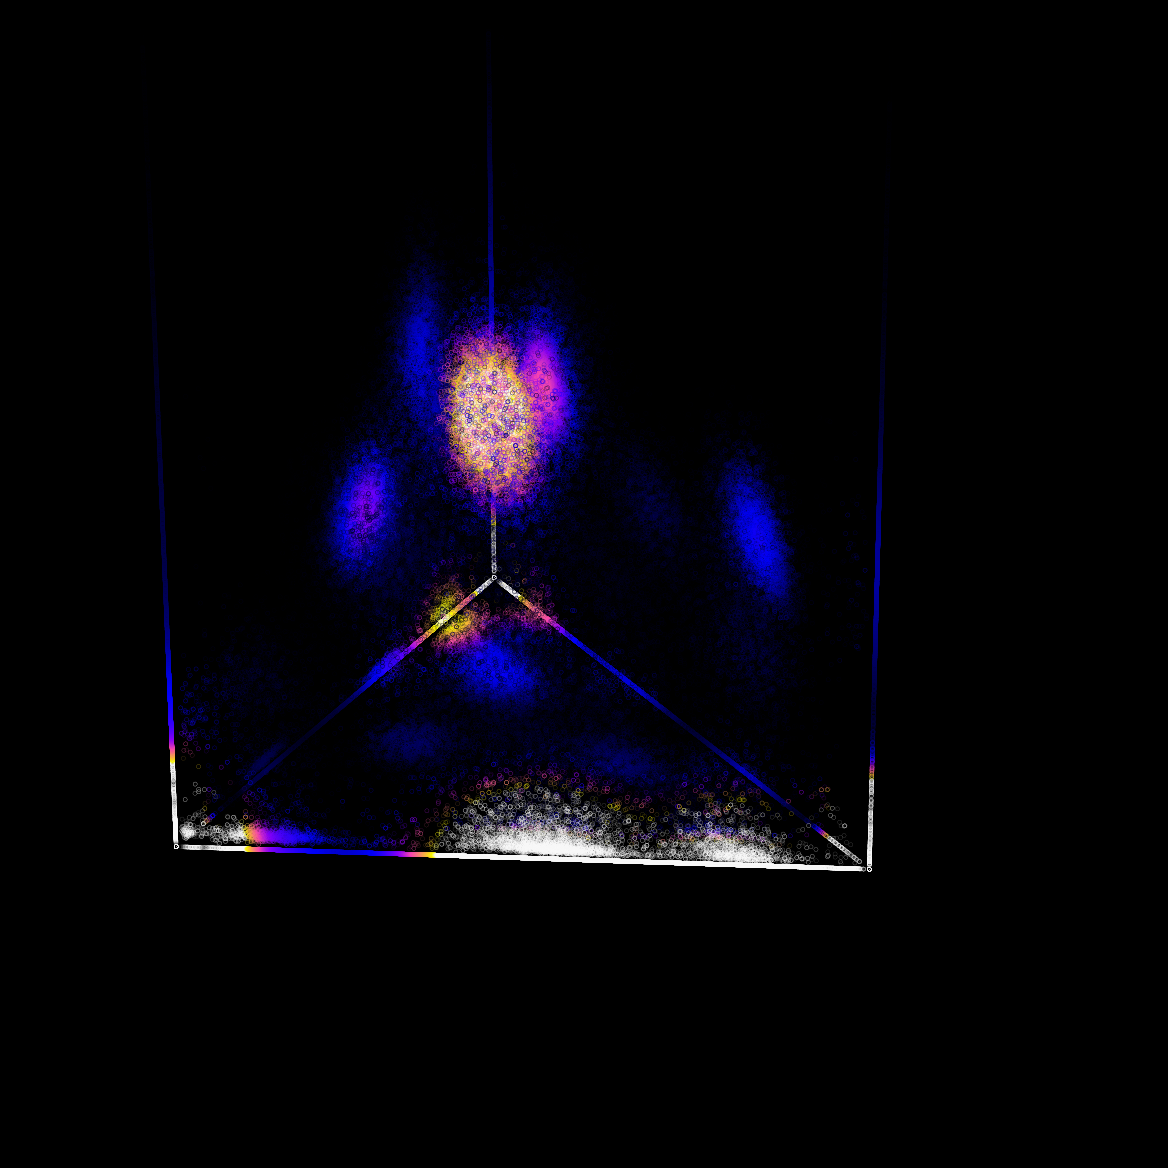

In [10]:
pretreat = intensity_all.sample(frac=1,replace=True, random_state=1)
sample = pretreat[['X_coor','Y_coor','G/A']]
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

mu, sigma = 0, 0.1 
x = np.array(sample['X_coor'])
y = np.array(sample['Y_coor'])
z = np.array(sample['G/A'])

xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=density, cmap=plt.cm.gnuplot2 ,s=0.0012,vmin=0, vmax=1)
ax.set_zlim3d(0,1.5)
fig.set_facecolor('black')
ax.set_facecolor('black') 
ax.grid(False) 
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.set_axis_off()
plt.savefig('3D_density_sampled_ctx_all_adjust.jpg')

In [19]:
import pandas as pd
from collections import Counter
spots = intensity_all[intensity_all['Gene']!='Other']
data = spots['z_in_pix'].value_counts()
print(data)
data.to_csv("spot number_un_normalize.csv",mode='a')

20     6880
23     6761
22     6616
24     6545
21     6539
       ... 
109       3
7         3
4         3
116       2
110       1
Name: z_in_pix, Length: 108, dtype: int64


In [13]:
# Save results
intensity_all = intensity_all.astype({'x_in_pix':int, 'y_in_pix':int,'z_in_pix':int})
intensity_all[['x_in_pix','y_in_pix','z_in_pix','Gene']].to_csv('mapped_genes_1000_short.csv')

In [14]:
from tqdm import tqdm
from glob import glob
import skimage
import os
rna_df = intensity_all[['x_in_pix','y_in_pix','z_in_pix','Gene']]
kernel = np.ones((3,3,3), dtype = np.uint16)
genes = set(rna_df['Gene'])

try:
    os.mkdir('./result_final')
except FileExistsError:
    pass

for gene in tqdm(genes):
    if glob(os.path.join('./result_final',f'{gene}.tif')):
        continue
    else:
        df = rna_df[rna_df['Gene']==gene]
        im = np.zeros(((121, 1929, 6415)),dtype=np.uint16)
        im[df['z_in_pix'],df['x_in_pix'],df['y_in_pix']] = 65535
        im = skimage.morphology.dilation(im, selem=kernel)
        imsave(f'./result_final/{gene}.tif',im.astype(np.uint16),check_contrast=False)


  0%|          | 0/31 [00:00<?, ?it/s]C:\Users\PC\AppData\Local\Temp\ipykernel_3252\97344174.py:21: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  im = skimage.morphology.dilation(im, selem=kernel)
100%|██████████| 31/31 [15:41<00:00, 30.36s/it]


In [17]:
intensity_all[intensity_all['Gene']=='PRISM_9']

,x_in_pix,y_in_pix,z_in_pix,R,Y,B,G,Scaled_R,Scaled_Ye,Scaled_G,Scaled_B,sum,R/A,Ye/A,B/A,G/A,X_coor,Y_coor,Gene
1,1296,3870,31,0,0,21289,0,0.0,0.0,0.0,14192.666667,14192.666667,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
2,2635,4496,85,0,0,21286,0,0.0,0.0,0.0,14190.666667,14190.666667,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
10,1794,728,69,0,0,20079,0,0.0,0.0,0.0,13386.000000,13386.000000,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
16,682,1627,95,0,0,19242,0,0.0,0.0,0.0,12828.000000,12828.000000,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
17,70,624,21,0,0,19137,0,0.0,0.0,0.0,12758.000000,12758.000000,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60523,2329,4407,93,0,0,6123,0,0.0,0.0,0.0,4082.000000,4082.000000,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
67555,162,3912,67,0,0,4349,0,0.0,0.0,0.0,2899.333333,2899.333333,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
97188,3643,2614,83,0,0,12684,0,0.0,0.0,0.0,8456.000000,8456.000000,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
118370,3698,200,44,0,0,5956,0,0.0,0.0,0.0,3970.666667,3970.666667,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9


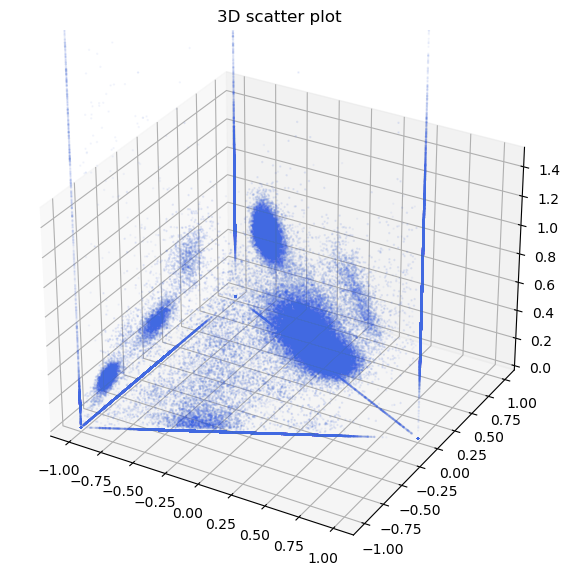

In [18]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(intensity_all['X_coor'], intensity_all['Y_coor'], intensity_all['G/A'], color = "royalblue",s=0.5,alpha=0.05)
ax.set_zlim3d(0,1.5)
plt.title("3D scatter plot")
plt.savefig('colorcoding_3D.jpg')

In [19]:
rna_df[rna_df['Gene']=='Other']

,x_in_pix,y_in_pix,z_in_pix,Gene
20,1712,3395,87,Other
65,1334,1796,55,Other
91,2317,3972,85,Other
108,1044,1256,68,Other
113,901,1024,89,Other
...,...,...,...,...
169051,393,273,79,Other
169052,477,3419,11,Other
169053,2573,3828,18,Other
169054,3127,1722,79,Other


In [20]:
# 
tree = KDTree(Test_coordinate_crop[['x_in_pix','y_in_pix','z_in_pix']])
pairs = tree.query_pairs(2)
len(pairs)

NameError: name 'Test_coordinate_crop' is not defined